Let's do some data analyis on the final submission results.

In [2]:
from erisk.spark import get_spark

spark = get_spark(cores=8, memory="8g")
spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/28 04:29:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/28 04:29:01 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
from pathlib import Path
import json
import re

# let's load the data manually so that we can process it with spark
paths = Path(".").glob("transcripts/**/*.json")
rows = []
for path in paths:
    data = json.loads(path.read_text())
    for datum in data:
        evaluation = datum["evaluation"]
        bdi_scores = evaluation["bdi_scores"]
        d = {
            "model": path.parent.name.lower(),
            "agent": path.stem.lower(),
            "input_message": datum["input_message"],
            "output_message": datum["output_message"],
            "next_step_reasoning": datum["next_step_reasoning"],
            # flatten the evaluation results
            "assessment_turn": int(evaluation["assessment_turn"]),
            "assessment_state": evaluation["assessment_state"],
            "assessment_complete": bool(evaluation["assessment_complete"]),
            "total_bdi_score": int(evaluation["total_bdi_score"]),
            "classification_suggestion": evaluation["classification_suggestion"],
            "confidence": float(evaluation["confidence"]),
            "bdi_scores": [
                {
                    # extract qdd_name e.g. q01_sadness
                    "question_number": int(re.search(r"q(\d+)_", k).group(1)),
                    "question_name": k.split("_", 1)[1],
                    "score": int(v["score"]),
                    "reason": v["reason"],
                }
                for k, v in bdi_scores.items()
            ],
        }
        rows.append(d)
len(rows)

767

In [4]:
from pyspark.sql import functions as F

df = spark.createDataFrame(rows).where(~F.col("model").isin("chatgpt-o1", "ensemble"))
df.printSchema()
df.show(3, vertical=True, truncate=100)

root
 |-- agent: string (nullable = true)
 |-- assessment_complete: boolean (nullable = true)
 |-- assessment_state: string (nullable = true)
 |-- assessment_turn: long (nullable = true)
 |-- bdi_scores: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: string (valueContainsNull = true)
 |-- classification_suggestion: string (nullable = true)
 |-- confidence: double (nullable = true)
 |-- input_message: string (nullable = true)
 |-- model: string (nullable = true)
 |-- next_step_reasoning: string (nullable = true)
 |-- output_message: string (nullable = true)
 |-- total_bdi_score: long (nullable = true)



-RECORD 0-------------------------------------------------------------------------------------------------------------------------
 agent                     | alex                                                                                                 
 assessment_complete       | false                                                                                                
 assessment_state          | Initializing                                                                                         
 assessment_turn           | 1                                                                                                    
 bdi_scores                | [{reason -> No information yet about sadness levels., score -> 0, question_number -> 1, question_... 
 classification_suggestion | Uncertain                                                                                            
 confidence                | 0.0                                                   

How many different bots are there, and how many different conversations did we have?

In [5]:
df.select("agent").distinct().orderBy("agent").show()
df.select("model").distinct().orderBy("model").show(truncate=False)
df.select("agent", "model").distinct().count()

+-------+
|  agent|
+-------+
|   alex|
|  elena|
|  ethan|
|gabriel|
|  james|
|  laura|
|  linda|
|  marco|
|  maria|
|   maya|
|   noah|
|  priya|
+-------+

+------------------------+
|model                   |
+------------------------+
|claude-3.7-sonnet       |
|gemini-2.0-flash        |
|gemini-2.5-pro-exp-03-25|
|gpt4o                   |
+------------------------+



48

In [6]:
df.where('assessment_state = "Finalized"').select("model", "agent").distinct().count()

45

In [7]:
# how many total conversations had longer turns than needed
(
    df.where('assessment_state = "Finalized"')
    .groupBy("model", "agent")
    .count()
    .where("count > 1")
).show()

+--------------------+-------+-----+
|               model|  agent|count|
+--------------------+-------+-----+
|    gemini-2.0-flash|  elena|    2|
|    gemini-2.0-flash|  marco|    3|
|    gemini-2.0-flash|  ethan|    3|
|gemini-2.5-pro-ex...|gabriel|    3|
|gemini-2.5-pro-ex...|  linda|    2|
|               gpt4o|   alex|    2|
+--------------------+-------+-----+



There are a couple of conversations that are not finalized, and there are a couple of conversations that go beyond the necessary assessment state.
We just return the length based on the actual conversation.

Okay now let's figure out the average length of the conversations.

In [8]:
def _words(c):
    return F.array_size(F.split(c, r"\s+"))


def count_words(grouping):
    for col, alias in [
        ("input_message", "in"),
        ("output_message", "out"),
        ("next_step_reasoning", "reason"),
    ]:
        (
            df.withColumn("input_words", _words("input_message"))
            .withColumn("output_words", _words("output_message"))
            .withColumn("reasoning_words", _words("next_step_reasoning"))
            .groupBy(grouping)
            .agg(
                F.count("*").alias(f"{alias}_n"),
                F.round(F.sum(_words(col)), 2).alias(f"{alias}_sum"),
                F.round(F.avg(_words(col)), 2).alias(f"{alias}_avg"),
                F.round(F.max(_words(col)), 2).alias(f"{alias}_max"),
                F.round(F.min(_words(col)), 2).alias(f"{alias}_min"),
                F.round(F.stddev(_words(col)), 2).alias(f"{alias}_std"),
            )
            .orderBy(grouping)
        ).show(truncate=False)


count_words("model")

+------------------------+----+------+------+------+------+------+
|model                   |in_n|in_sum|in_avg|in_max|in_min|in_std|
+------------------------+----+------+------+------+------+------+
|claude-3.7-sonnet       |138 |30702 |222.48|419   |1     |90.67 |
|gemini-2.0-flash        |121 |17011 |140.59|216   |1     |56.46 |
|gemini-2.5-pro-exp-03-25|135 |20167 |149.39|251   |1     |60.45 |
|gpt4o                   |130 |17749 |136.53|235   |1     |55.29 |
+------------------------+----+------+------+------+------+------+

+------------------------+-----+-------+-------+-------+-------+-------+
|model                   |out_n|out_sum|out_avg|out_max|out_min|out_std|
+------------------------+-----+-------+-------+-------+-------+-------+
|claude-3.7-sonnet       |138  |23291  |168.78 |326    |16     |63.31  |
|gemini-2.0-flash        |121  |4814   |39.79  |93     |10     |15.87  |
|gemini-2.5-pro-exp-03-25|135  |13654  |101.14 |192    |1      |41.6   |
|gpt4o                   

Run the same analysis on the agents.
This turns out to be less interesting because the responses are more consistent.

In [9]:
count_words("agent")

+-------+----+------+------+------+------+------+
|agent  |in_n|in_sum|in_avg|in_max|in_min|in_std|
+-------+----+------+------+------+------+------+
|alex   |47  |7463  |158.79|283   |1     |67.52 |
|elena  |41  |7467  |182.12|319   |1     |81.06 |
|ethan  |47  |7083  |150.7 |274   |1     |67.3  |
|gabriel|46  |8642  |187.87|378   |1     |91.49 |
|james  |39  |5729  |146.9 |266   |1     |67.72 |
|laura  |44  |7224  |164.18|259   |1     |63.8  |
|linda  |41  |6393  |155.93|267   |1     |64.4  |
|marco  |39  |5558  |142.51|288   |1     |72.06 |
|maria  |41  |5957  |145.29|253   |1     |65.06 |
|maya   |43  |7118  |165.53|376   |1     |83.52 |
|noah   |51  |8719  |170.96|369   |1     |77.3  |
|priya  |45  |8276  |183.91|419   |1     |96.61 |
+-------+----+------+------+------+------+------+

+-------+-----+-------+-------+-------+-------+-------+
|agent  |out_n|out_sum|out_avg|out_max|out_min|out_std|
+-------+-----+-------+-------+-------+-------+-------+
|alex   |47   |4556   |96.94  |

Let's do the same as above, but count the average number of rounds before the conversation is finalized.

In [10]:
other = {
    "model": "agent",
    "agent": "model",
}

for grouping in ["model", "agent"]:
    (
        df.groupBy(grouping, other[grouping])
        .agg(
            F.max("assessment_turn").alias("max_turn"),
            F.max("confidence").alias("max_conf"),
        )
        .groupBy(grouping)
        .agg(
            # round to 2 decimal places
            F.round(F.avg("max_turn"), 2).alias("avg_turn"),
            F.round(F.avg("max_conf"), 2).alias("avg_conf"),
            F.round(F.stddev("max_turn"), 2).alias("std_turn"),
            F.round(F.stddev("max_conf"), 2).alias("std_conf"),
        )
        .orderBy(grouping)
    ).show(truncate=False)

+------------------------+--------+--------+--------+--------+
|model                   |avg_turn|avg_conf|std_turn|std_conf|
+------------------------+--------+--------+--------+--------+
|claude-3.7-sonnet       |11.5    |0.96    |1.57    |0.02    |
|gemini-2.0-flash        |10.0    |0.97    |2.45    |0.02    |
|gemini-2.5-pro-exp-03-25|11.33   |0.89    |1.61    |0.06    |
|gpt4o                   |11.0    |0.9     |1.86    |0.08    |
+------------------------+--------+--------+--------+--------+

+-------+--------+--------+--------+--------+
|agent  |avg_turn|avg_conf|std_turn|std_conf|
+-------+--------+--------+--------+--------+
|alex   |11.75   |0.91    |0.96    |0.08    |
|elena  |10.25   |0.98    |1.71    |0.02    |
|ethan  |11.75   |0.92    |2.06    |0.08    |
|gabriel|11.75   |0.91    |2.22    |0.06    |
|james  |9.75    |0.91    |2.06    |0.07    |
|laura  |11.0    |0.94    |3.46    |0.02    |
|linda  |10.25   |0.92    |1.5     |0.04    |
|marco  |9.75    |0.98    |0.96    

The number of turns is consistent among all of the models and agents at about 10.
There is likely sensitivity to the prompt given this information.
Average confidence is fairly high. Are some models more confident than others at certain time steps?

In [11]:
conf_over_time = {}

other = {
    "model": "agent",
    "agent": "model",
}

for grouping in ["model", "agent"]:
    res = (
        df.withColumn("turn", F.col("assessment_turn"))
        .groupBy(grouping, other[grouping], "turn")
        .agg(
            F.max("confidence").alias("confidence")
            # also the scores..
        )
        .groupBy(grouping, "turn")
        .agg(
            # round to 2 decimal places
            F.round(F.avg("confidence"), 2).alias("avg_conf"),
            F.round(F.stddev("confidence"), 2).alias("std_conf"),
        )
        # pivot the turn into columns
        .groupBy(grouping)
        .pivot("turn")
        .agg(
            F.first("avg_conf").alias("avg_conf"),
        )
        .orderBy(grouping)
    )
    conf_over_time[grouping] = res
    res.show(truncate=False)


+------------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|model                   |1   |2   |3   |4   |5   |6   |7   |8   |9   |10  |11  |12  |13  |14  |15  |16  |
+------------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|claude-3.7-sonnet       |0.0 |0.2 |0.36|0.5 |0.6 |0.7 |0.77|0.83|0.88|0.91|0.93|0.95|0.94|0.95|NULL|NULL|
|gemini-2.0-flash        |0.05|0.5 |0.66|0.76|0.84|0.9 |0.92|0.93|0.93|0.94|0.96|0.96|0.97|0.98|NULL|NULL|
|gemini-2.5-pro-exp-03-25|0.01|0.24|0.38|0.48|0.58|0.65|0.71|0.76|0.81|0.84|0.83|0.87|0.89|0.9 |NULL|NULL|
|gpt4o                   |0.0 |0.36|0.47|0.54|0.62|0.65|0.71|0.75|0.8 |0.83|0.85|0.83|0.8 |0.85|0.9 |1.0 |
+------------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+

+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|agent  |1   |2   |3   |4   |5   |6   |7   |8   |9   

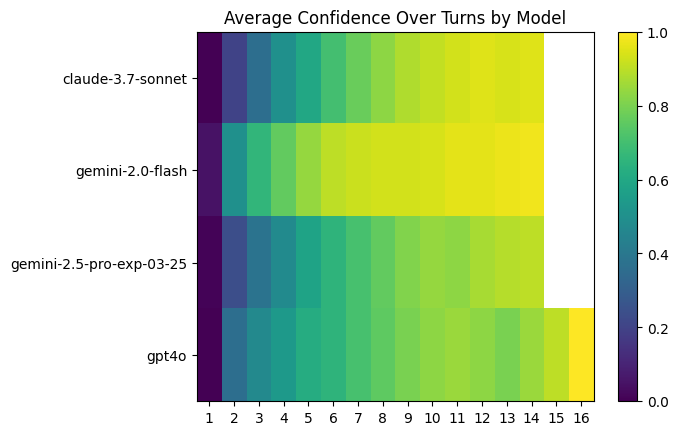

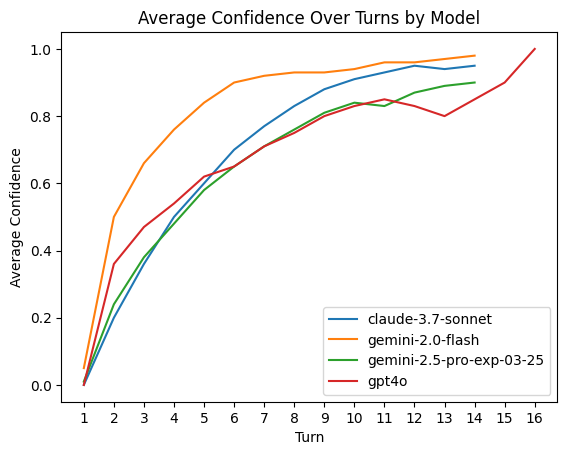

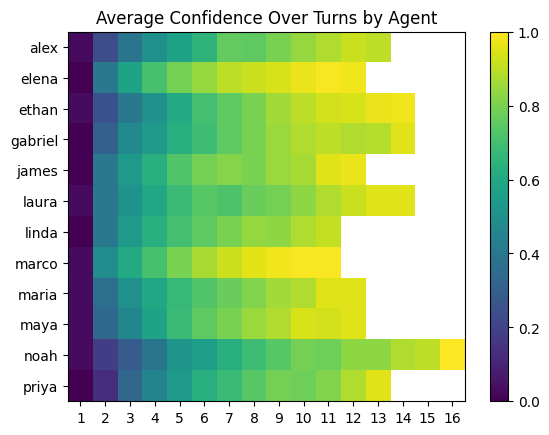

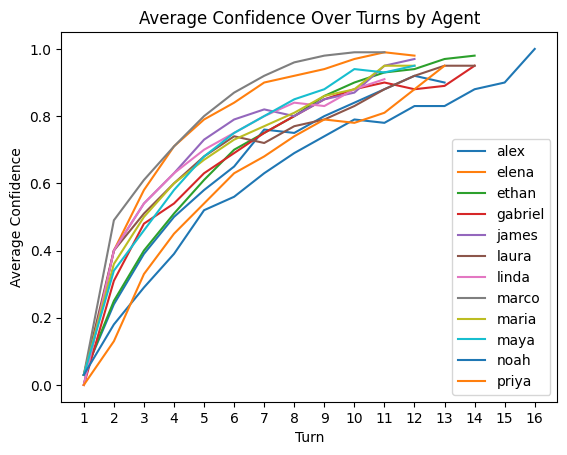

In [12]:
import matplotlib.pyplot as plt

for name in ["model", "agent"]:
    # show as a heatmap
    res = conf_over_time[name].toPandas()
    plt.imshow(
        res.iloc[:, 1:].values,
        cmap="viridis",
        aspect="auto",
        interpolation="nearest",
    )
    plt.colorbar()
    plt.xticks(
        range(len(res.columns) - 1),
        res.columns[1:],
    )
    plt.yticks(
        range(len(res)),
        res[name].values,
    )
    plt.title(f"Average Confidence Over Turns by {name.capitalize()}")
    plt.show()

    # instead just show line plots
    for i in range(0, len(res)):
        plt.plot(
            res.columns[1:],
            res.iloc[i, 1:].values,
            label=res[name].iloc[i],
        )
    plt.xlabel("Turn")
    plt.ylabel("Average Confidence")
    plt.title(f"Average Confidence Over Turns by {name.capitalize()}")
    plt.legend()
    plt.show()

Let's now turn over to the bdi scores.
Let's take the final bdi score and see how they vary across models.
We'll have a bdi score and a bdi vector.

Questions:

- Can LLMs do math (interesting side question)
- What is the average final scores across all models.
- What do scores look like over time? How long should it take to come to a conclusion?
- What do the BDI vectors look like on a scatter plot? Are there obvious clusters?

In [13]:
@F.udf("array<int>")
def bdi_vector(bdi_scores: list[dict]) -> list[int]:
    # NOTE: i could probably explode, sort, and array collect, but
    # this is a lot easier...
    vec = [0] * 21  # BDI has 21 questions
    for item in bdi_scores:
        vec[int(item["question_number"]) - 1] = int(item["score"])
    return vec


bdi = (
    df.select(
        "model",
        "agent",
        F.col("assessment_turn").alias("turn"),
        bdi_vector("bdi_scores").alias("bdi_vector"),
        F.col("total_bdi_score").alias("est_bdi_score"),
    ).withColumn(
        "bdi_score", F.aggregate(F.col("bdi_vector"), F.lit(0), lambda acc, x: acc + x)
    )
).cache()
bdi.show(truncate=False)

+-----------------+-------+----+---------------------------------------------------------------+-------------+---------+
|model            |agent  |turn|bdi_vector                                                     |est_bdi_score|bdi_score|
+-----------------+-------+----+---------------------------------------------------------------+-------------+---------+
|claude-3.7-sonnet|alex   |1   |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]|0            |0        |
|claude-3.7-sonnet|alex   |2   |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 3, 1, 0, 0, 0, 0]|7            |7        |
|claude-3.7-sonnet|alex   |3   |[0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 3, 2, 0, 0, 0, 0]|11           |11       |
|claude-3.7-sonnet|alex   |4   |[1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 3, 2, 0, 0, 0, 0]|15           |16       |
|claude-3.7-sonnet|alex   |5   |[1, 2, 1, 2, 0, 0, 1, 1, 0, 0, 1, 1, 2, 0, 1, 3, 2, 0, 0, 0, 0]|17           |18       |
|claude-3.7-sonnet|alex   |6   |

Average score difference per model

In [14]:
(
    bdi.withColumn("diff", F.expr("abs(bdi_score - est_bdi_score)"))
    .withColumn("is_correct", F.when(F.col("diff") == 0, True).otherwise(False))
    .groupBy("model")
    .agg(
        F.round(F.avg("diff"), 2).alias("avg_diff"),
        F.round(F.stddev("diff"), 2).alias("std_diff"),
        F.sum(F.when(F.col("is_correct"), 1).otherwise(0)).alias("correct_n"),
        F.count("*").alias("n"),
        F.round(
            F.sum(F.when(F.col("is_correct"), 1).otherwise(0)) / F.count("*"), 2
        ).alias("correct_pct"),
    )
).show(truncate=False)

+------------------------+--------+--------+---------+---+-----------+
|model                   |avg_diff|std_diff|correct_n|n  |correct_pct|
+------------------------+--------+--------+---------+---+-----------+
|claude-3.7-sonnet       |1.3     |1.57    |57       |138|0.41       |
|gemini-2.0-flash        |1.68    |1.52    |38       |121|0.31       |
|gemini-2.5-pro-exp-03-25|0.87    |1.41    |83       |135|0.61       |
|gpt4o                   |2.62    |4.45    |30       |130|0.23       |
+------------------------+--------+--------+---------+---+-----------+



These results seem reasonable to me.
Gemini pro does particularly well at math because its a stronger reasoning model.

TODO: include initial o1 results for this since we do have the data...

We can then look at the final average scores.

In [15]:
for grouping in ["model", "agent"]:
    max_turn = bdi.groupBy("model", "agent").agg(F.max("turn").alias("turn"))
    (
        bdi.join(max_turn, on=["model", "agent", "turn"], how="inner")
        .groupBy(grouping)
        .agg(
            F.round(F.avg("bdi_score"), 2).alias("avg_score"),
            F.round(F.stddev("bdi_score"), 2).alias("std_score"),
            F.count("*").alias("n"),
        )
        .orderBy("avg_score")
    ).show(truncate=False)

+------------------------+---------+---------+---+
|model                   |avg_score|std_score|n  |
+------------------------+---------+---------+---+
|gpt4o                   |10.92    |9.7      |12 |
|gemini-2.0-flash        |21.58    |8.14     |12 |
|gemini-2.5-pro-exp-03-25|22.0     |11.14    |12 |
|claude-3.7-sonnet       |28.08    |14.76    |12 |
+------------------------+---------+---------+---+

+-------+---------+---------+---+
|agent  |avg_score|std_score|n  |
+-------+---------+---------+---+
|maya   |1.0      |1.41     |4  |
|priya  |6.0      |4.9      |4  |
|noah   |12.75    |5.25     |4  |
|ethan  |18.75    |8.42     |4  |
|gabriel|19.25    |12.55    |4  |
|alex   |22.0     |10.23    |4  |
|james  |23.0     |8.52     |4  |
|maria  |26.0     |7.44     |4  |
|linda  |26.25    |10.94    |4  |
|laura  |28.25    |10.53    |4  |
|marco  |28.5     |14.39    |4  |
|elena  |36.0     |6.73     |4  |
+-------+---------+---------+---+



Now let's do the average scores over time.
We'll just look at the line plots.

+------------------------+---+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|model                   |1  |2   |3   |4    |5    |6    |7    |8    |9    |10   |11   |12   |13   |14   |15   |16   |
+------------------------+---+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|claude-3.7-sonnet       |0.0|6.33|10.5|15.08|17.83|20.33|22.75|24.0 |26.08|26.92|27.58|27.75|28.0 |28.08|28.08|28.08|
|gemini-2.0-flash        |0.0|6.33|9.92|13.25|15.5 |17.67|19.42|20.42|21.0 |21.33|21.58|21.58|21.58|21.58|21.58|21.58|
|gemini-2.5-pro-exp-03-25|0.0|5.42|9.08|10.67|13.58|16.75|18.58|20.08|20.75|21.25|21.58|21.92|22.0 |22.0 |22.0 |22.0 |
|gpt4o                   |0.0|6.92|8.58|10.67|11.25|10.83|10.83|11.08|11.0 |11.0 |11.0 |11.0 |11.0 |10.92|10.92|10.92|
+------------------------+---+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+



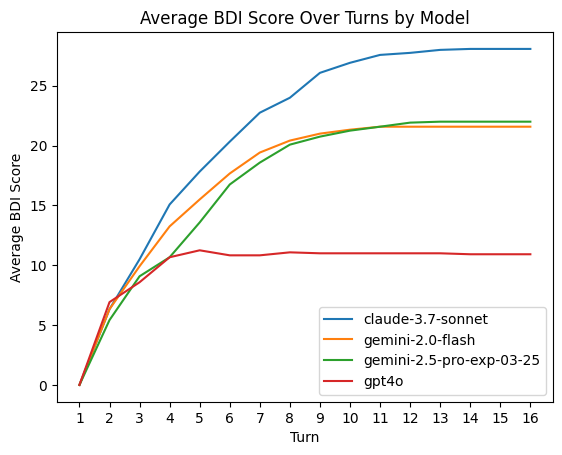

+-------+---+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|agent  |1  |2    |3    |4    |5    |6    |7    |8    |9    |10   |11   |12   |13   |14   |15   |16   |
+-------+---+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|alex   |0.0|5.5  |9.25 |12.25|14.25|16.5 |18.0 |19.5 |21.0 |21.25|21.5 |22.0 |22.0 |22.0 |22.0 |22.0 |
|elena  |0.0|10.5 |16.5 |21.5 |24.25|29.25|32.25|33.75|35.5 |35.5 |36.0 |36.0 |36.0 |36.0 |36.0 |36.0 |
|ethan  |0.0|3.0  |5.5  |8.0  |10.5 |13.25|14.75|15.5 |17.25|18.5 |18.75|18.75|18.75|18.75|18.75|18.75|
|gabriel|0.0|4.0  |10.0 |11.0 |14.0 |13.5 |15.25|16.25|16.75|17.75|18.75|18.75|19.0 |19.25|19.25|19.25|
|james  |0.0|8.5  |11.0 |15.25|17.25|19.0 |20.75|21.5 |22.25|22.5 |23.0 |23.0 |23.0 |23.0 |23.0 |23.0 |
|laura  |0.0|8.75 |12.5 |17.25|20.25|22.25|24.0 |24.75|25.5 |26.25|27.0 |27.75|28.25|28.25|28.25|28.25|
|linda  |0.0|9.25 |14.5 |16.5 |19.0 |21.75|24.25|25.0 |25.5 |26.

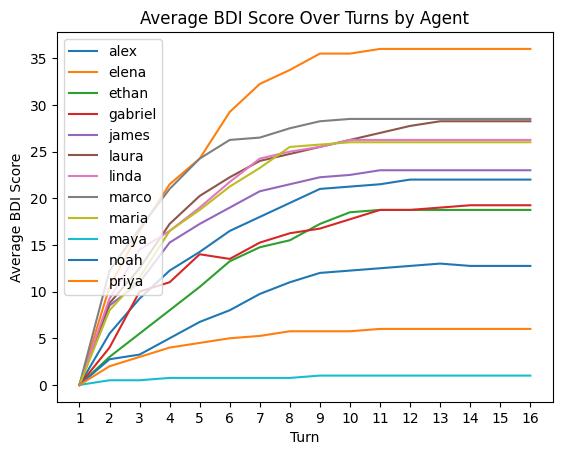

In [16]:
# TODO: have to implement this for the confidence scores too...
def fill_backwards(df):
    """This basically fills the last few turns as the last seen score for models that are cut short."""
    max_turn = df.groupBy("model", "agent").agg(F.max("turn").alias("turn"))
    max_value = df.join(max_turn, on=["model", "agent", "turn"], how="inner").select(
        "model", "agent", F.col("bdi_score").alias("max_value")
    )
    all_combos = (
        df.select("model", "agent").distinct().crossJoin(df.select("turn").distinct())
    )
    return (
        # make sure every turn is present for each model and agent
        df.join(all_combos, on=["model", "agent", "turn"], how="right")
        # now fill missing values from max_value
        .join(max_value, on=["model", "agent"], how="left")
        .withColumn(
            "bdi_score",
            F.when(F.col("bdi_score").isNull(), F.col("max_value")).otherwise(
                F.col("bdi_score")
            ),
        )
    )


for grouping in ["model", "agent"]:
    res = (
        fill_backwards(bdi)
        .groupBy(grouping, "turn")
        .agg(
            F.round(F.avg("bdi_score"), 2).alias("avg_bdi_score"),
            F.round(F.stddev("bdi_score"), 2).alias("std_bdi_score"),
        )
        .groupBy(grouping)
        .pivot("turn")
        .agg(F.first("avg_bdi_score").alias("avg_bdi_score"))
        .orderBy(grouping)
    )
    res.show(truncate=False)
    pdf = res.toPandas()
    for i in range(0, len(pdf)):
        plt.plot(
            pdf.columns[1:],
            pdf.iloc[i, 1:].values,
            label=pdf[grouping].iloc[i],
        )
    plt.xlabel("Turn")
    plt.ylabel("Average BDI Score")
    plt.title(f"Average BDI Score Over Turns by {grouping.capitalize()}")
    plt.legend()
    plt.show()

Finally, let's look at the bdi vectors.
We'll just do umap over the final bdi vector and see if there's clustering behavior.
PCA is an option and would give intepretable results, but UMAP looks more interesting.

In [17]:
last_turn = (
    bdi.groupBy("model", "agent")
    .agg(F.max("turn").alias("turn"))
)

bdi_last = (
    bdi.join(last_turn, on=["model", "agent", "turn"], how="inner")
    .select("model", "agent", "turn", "bdi_score", "bdi_vector")
    .orderBy("bdi_score")
    .toPandas()
)
bdi_last.head()

,model,agent,turn,bdi_score,bdi_vector
0,claude-3.7-sonnet,maya,10,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,gemini-2.5-pro-exp-03-25,maya,10,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,gpt4o,maya,11,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,claude-3.7-sonnet,priya,9,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,gpt4o,priya,12,2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [18]:
import umap
import numpy as np

X = np.stack(bdi_last["bdi_vector"].values)
g = umap.UMAP(metric="euclidean", random_state=42).fit_transform(X)


/storage/home/hcoda1/8/amiyaguchi3/clef/erisk-2025/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/storage/home/hcoda1/8/amiyaguchi3/clef/erisk-2025/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/storage/home/hcoda1/8/amiyaguchi3/clef/erisk-2025/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 1.0, 'UMAP Projection of BDI Scores by Model')

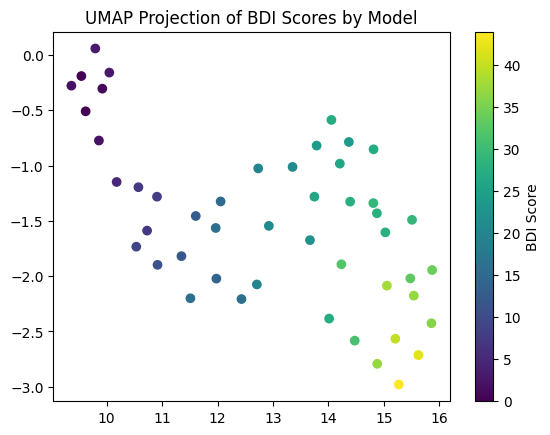

In [19]:
plt.scatter(g[:, 0], g[:, 1], c=bdi_last["bdi_score"], cmap="viridis")
plt.colorbar(label="BDI Score")
plt.title("UMAP Projection of BDI Scores by Model")

Text(0.5, 1.0, 'UMAP Projection of BDI Scores by Agent')

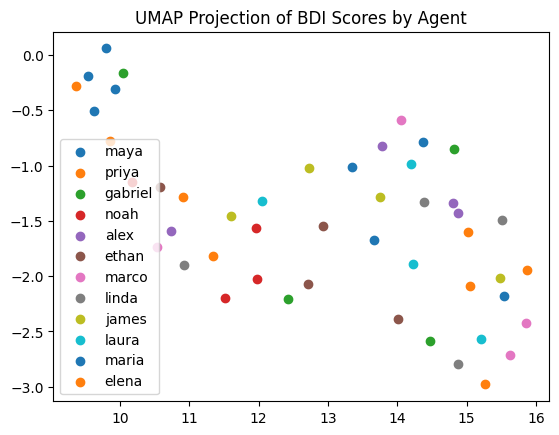

In [20]:
# now color them by agent
for agent in bdi_last["agent"].unique():
    mask = bdi_last["agent"] == agent
    plt.scatter(
        g[mask, 0],
        g[mask, 1],
        label=agent,
    )
plt.legend()
plt.title("UMAP Projection of BDI Scores by Agent")

The last plot is not that interesting because there aren't enough data points to see any real clustering behavior.
It's also hard to tell who is who.

Finally let's make some polar plots with the vectors.

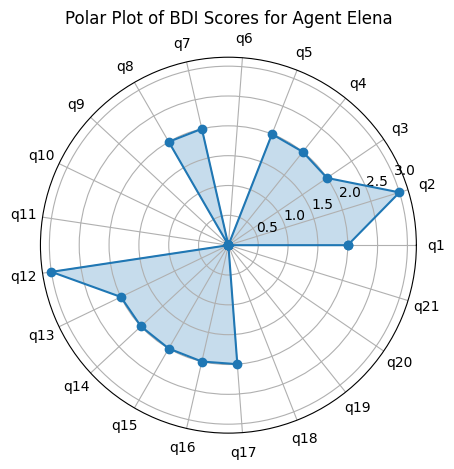

In [21]:
# polar plot of the first row
import matplotlib.pyplot as plt
import numpy as np

x = bdi_last[bdi_last["agent"] == "elena"].iloc[0]["bdi_vector"]
x = np.array(x)  # convert to numpy array if not already

theta = np.linspace(0, 2 * np.pi, len(x), endpoint=False)
theta_closed = np.concatenate((theta, [theta[0]]))  # close the circle
r = np.concatenate((x, [x[0]]))  # close the circle
ax = plt.subplot(111, projection='polar')
ax.plot(theta_closed, r, marker='o')
ax.fill(theta_closed, r, alpha=0.25)
ax.set_xticks(theta)  # set the ticks to the angles
ax.set_xticklabels([f"q{i+1}" for i in range(len(x))])  # set the labels to q1, q2, ...
plt.title("Polar Plot of BDI Scores for Agent Elena")
plt.tight_layout()
plt.show()

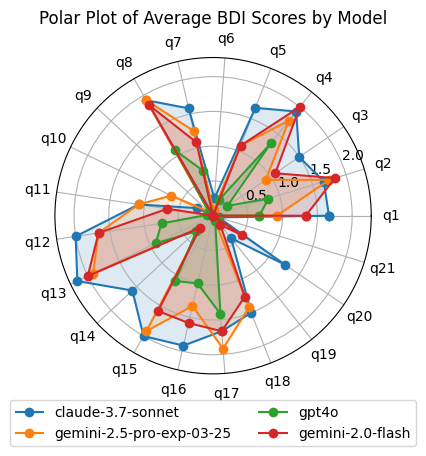

In [24]:
import numpy as np

# Average the BDI vectors for each model and plot as polar plots
import matplotlib.pyplot as plt

models = bdi_last["model"].unique()
theta = np.linspace(0, 2 * np.pi, 21, endpoint=False)
theta_closed = np.concatenate((theta, [theta[0]]))  # close the circle

ax = plt.subplot(111, projection='polar')

for model in models:
    x = np.stack(bdi_last[bdi_last["model"] == model]["bdi_vector"].values).mean(axis=0)
    r = np.concatenate((x, [x[0]]))  # close the circle
    ax.plot(theta_closed, r, marker='o', label=model)
    ax.fill(theta_closed, r, alpha=0.15)

ax.set_xticks(theta)
ax.set_xticklabels([f"q{i+1}" for i in range(21)])
plt.title("Polar Plot of Average BDI Scores by Model")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()